In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers

from tensorflow.keras import initializers, layers, Model, Input

2025-11-03 15:57:20.330569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Fitting a 1d function with a deep neural network

## Aim

To find the the best architecture and training setup to fit a pre-defined function

$f(x) = 10\sin(10 x) + (x-1)(x+2)(x-1/2)+80 e^{-10*(x-2)^2} $

In [2]:
# let's choose a simple 1->1 function to train
def f(x):
    return 10*np.sin(10*x)+(x-3)*(x+2)*(x-1/2)+80*np.exp(-(x-2)**2/0.1)

In [3]:
# Data
x = np.linspace(-5, 5, 4000).reshape(-1,1).astype(np.float32)
y = f(x).astype(np.float32)

# optionally oversample near the bump (x~2)
extra = np.random.normal(loc=2.0, scale=0.05, size=(1000,1)).astype(np.float32)
x = np.vstack([x, extra])
y = np.vstack([y, f(extra).astype(np.float32)])

# shuffle, train/val split
idx = np.random.permutation(len(x))
x, y = x[idx], y[idx]
split = int(0.8*len(x))
x_train, x_val = x[:split], x[split:]
y_train, y_val = y[:split], y[split:]

# scale x (important)
x_mean, x_std = x_train.mean(), x_train.std()
x_train_s = (x_train - x_mean) / x_std
x_val_s   = (x_val   - x_mean) / x_std

In [4]:
tf.keras.backend.clear_session()

In [5]:
def make_baseline():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss='mse', metrics=['mse'])
    return model

model = make_baseline()
model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, min_delta=1e-4, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
]

st = time.time()

history = model.fit(x_train_s, y_train, validation_data=(x_val_s, y_val),
                    epochs=2000, batch_size=64, callbacks=callbacks, verbose=0)

et = time.time()
print('trained in ',(et-st)/60.,' mins')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               256       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33,409
Trainable params: 33,409
Non-trainable params: 0
_________________________________________________________________


2025-11-03 15:57:27.346370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Epoch 923: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 987: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 1006: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 1134: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 1144: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 1189: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 1275: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 1301: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 1332: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 1342: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch: 1322.
Epoch 1372: early stopping
trained in  2.113964680830638  mins


In [6]:
max(history.history['val_loss']), min(history.history['val_loss'])

(1504.9407958984375, 503.6753845214844)

In [7]:
def fourier_features(x, B):
    # x shape (N,1), B shape (D,)
    x_proj = 2*np.pi * x @ B.reshape(1,-1)  # (N,D)
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

# choose bandwidth of random features:
D = 64
scale = 10.0   # higher scale -> can represent higher frequencies; try values 5..50
B = np.random.normal(scale=scale, size=(D,)).astype(np.float32)

# precompute fourier features for dataset
X_ff_train = fourier_features(x_train_s, B)
X_ff_val   = fourier_features(x_val_s, B)

def make_ff_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
    return model

model_ff = make_ff_model(X_ff_train.shape[1])
model_ff.summary()

st = time.time()

history_ff = model_ff.fit(X_ff_train, y_train, validation_data=(X_ff_val, y_val),
                          epochs=10000, batch_size=64, callbacks=callbacks, verbose=0)

et = time.time()
print('trained in ',(et-st)/60.,' mins')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 99,073
Trainable params: 99,073
Non-trainable params: 0
_________________________________________________________________

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 76: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Ep

In [8]:
max(history_ff.history['val_loss']), min(history_ff.history['val_loss'])

(240.06919860839844, 0.0023442970123142004)

In [9]:
# apparently the algorithm is very sensitive to the input range
xmin, xmax = x.min(), x.max()
x_scaled = 2*(x - xmin)/(xmax - xmin) - 1.0

# shuffle and split
perm = np.random.permutation(len(x_scaled))
x_scaled, y = x_scaled[perm], y[perm]
split = int(0.8 * len(x_scaled))
x_train, x_val = x_scaled[:split], x_scaled[split:]
y_train, y_val = y[:split], y[split:]

In [10]:
# SIREN layer / initializers
class SineActivation(layers.Layer):
    def __init__(self, w0=1.0):
        super().__init__()
        self.w0 = w0
    def call(self, x):
        return tf.sin(self.w0 * x)

def siren_first_init(in_dim):
    # U(-1/in_dim, 1/in_dim)
    limit = 1.0 / in_dim
    return initializers.RandomUniform(-limit, limit)

def siren_hidden_init(in_dim, w0):
    # U(-sqrt(6/in_dim)/w0, sqrt(6/in_dim)/w0)
    limit = np.sqrt(6.0 / in_dim) / w0
    return initializers.RandomUniform(-limit, limit)

def build_siren(in_features=1, hidden_units=128, hidden_layers=3, w0=30.0):
    inp = Input(shape=(in_features,))
    # first dense: use in_features for init
    x = layers.Dense(hidden_units,
                     kernel_initializer=siren_first_init(in_features),
                     bias_initializer='zeros')(inp)
    x = SineActivation(w0=w0)(x)   # first layer uses high w0
    # subsequent layers
    for _ in range(hidden_layers):
        x = layers.Dense(hidden_units,
                         kernel_initializer=siren_hidden_init(hidden_units, w0=1.0),
                         bias_initializer='zeros')(x)
        x = SineActivation(w0=1.0)(x)  # later layers use w0=1.0
    out = layers.Dense(1,
                       kernel_initializer=initializers.RandomUniform(-np.sqrt(6.0/hidden_units)/1.0,
                                                                      np.sqrt(6.0/hidden_units)/1.0),
                       bias_initializer='zeros')(x)
    return Model(inp, out)

# build model and compile with a small lr
model_siren = build_siren(in_features=1, hidden_units=128, hidden_layers=4, w0=30.0)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)   # lower LR often better
model_siren.compile(optimizer=opt, loss='mse', metrics=['mse'])
model_siren.summary()

# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, min_delta=1e-6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-7, verbose=1)
]

st = time.time()
history_siren = model_siren.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=2000, batch_size=64, callbacks=callbacks, verbose=0)
et = time.time()
print('trained in ',(et-st)/60.,' mins')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_7 (Dense)             (None, 128)               256       
                                                                 
 sine_activation (SineActiva  (None, 128)              0         
 tion)                                                           
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 sine_activation_1 (SineActi  (None, 128)              0         
 vation)                                                         
                                                                 
 dense_9 (Dense)             (None, 128)               16512 

In [11]:
max(history_siren.history['val_loss']), min(history_siren.history['val_loss'])

(2006.155517578125, 0.00040083826752379537)

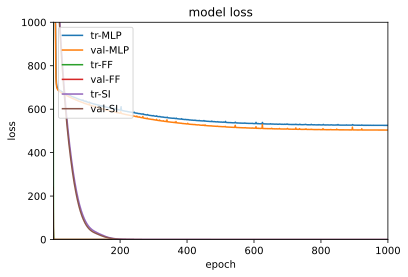

In [42]:
# now we can plot the history to see how the loss function for the
# training and validation set changed with epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.plot(history_ff.history['loss'])
plt.plot(history_ff.history['val_loss'])

plt.plot(history_siren.history['loss'])
plt.plot(history_siren.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['tr-MLP', 'val-MLP', 'tr-FF', 'val-FF', 'tr-SI', 'val-SI'], loc='upper left')
plt.xlim([1,1000])
plt.ylim([0,1000])
plt.show()

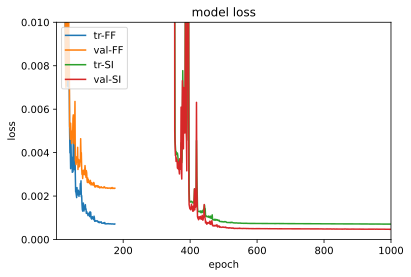

In [47]:
plt.plot(history_ff.history['loss'])
plt.plot(history_ff.history['val_loss'])

plt.plot(history_siren.history['loss'])
plt.plot(history_siren.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['tr-FF', 'val-FF', 'tr-SI', 'val-SI'], loc='upper left')
plt.xlim([1,1000])
plt.ylim([0,0.01])
plt.show()

In [14]:
x_test = np.linspace(-5, 5, 1000).reshape(-1,1).astype(np.float32)
y_test = f(x_test).astype(np.float32)
x_test_s   = (x_test   - x_mean) / x_std
y_test_pred = model.predict(x_test_s)
X_ff_test   = fourier_features(x_test_s, B)
y_ff_test_pred = model_ff.predict(X_ff_test)
x_test_scaled = 2*(x_test - xmin)/(xmax - xmin) - 1.0
y_siren_test_pred = model_siren.predict(x_test_scaled)

32/32 [==============================] - 0s 953us/step


Text(0.5, 0, 'x')

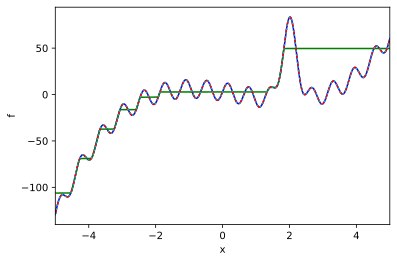

In [17]:
plt.plot(x_test, y_test, 'b')
plt.plot(x_test, y_test_pred, 'g')
plt.plot(x_test, y_ff_test_pred, 'r', linestyle='dashed')
plt.plot(x_test, y_siren_test_pred, 'c', linestyle='dotted')
plt.xlim([-5,5])
plt.ylabel('f')
plt.xlabel('x')

Text(0.5, 0, 'x')

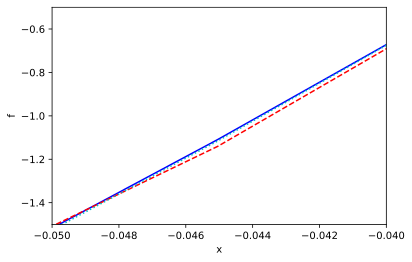

In [23]:
plt.plot(x_test, y_test, 'b')
plt.plot(x_test, y_ff_test_pred, 'r', linestyle='dashed')
plt.plot(x_test, y_siren_test_pred, 'c', linestyle='dotted')
plt.xlim([-0.05,-0.04])
plt.ylim([-1.5,-0.5])
plt.ylabel('f')
plt.xlabel('x')